Following [a simple but efficient real-time voice activity detection
algorithm](https://www.eurasip.org/Proceedings/Eusipco/Eusipco2009/contents/papers/1569192958.pdf).

In [1]:
%matplotlib notebook


import math
import IPython.display as ipd
import matplotlib.pyplot as plt
import torch
import torchaudio

In [2]:
# Voice sound
dataset = torchaudio.datasets.YESNO("~/yesno")
waveform = dataset[0][0]
sample_rate = 8 * 10**3

# Train sound
# filename = "_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav"
# waveform, sample_rate = torchaudio.load(filename)

# Convert to mono    
waveform = waveform.mean(0).view(1,-1)

There are three criteria to decide if a frame contains speech: energy, most dominant frequency, and spectral flatness. If any two of those are higher than a minimum plus a threshold, then the frame contains speech. In the offline case, the list of frames is postprocessed to remove too short silence and speech sequences. In the online case here, inertia is added before switching from speech to silence or vice versa.

In [3]:
def compute_spectral_flatness(frame):
    EPSILON = 0.01
    n = frame.nonzero().size(0)
    geometric_mean = torch.exp((EPSILON + frame).log().mean(-1)) - EPSILON
    arithmetic_mean = frame.mean(-1)
    return -10 * torch.log10(EPSILON + geometric_mean/arithmetic_mean)

def compute_energy(frame):
    return frame.pow(2).sum(-1)


class VoiceActivityDetection(object):

    def __init__(self):

        self.num_init_frames = 30
        self.ignore_silent_count = 10
        self.ignore_speech_count = 5

        self.energy_prim_thresh = 40
        self.frequency_prim_thresh = 5
        self.spectral_flatness_prim_thresh = 3
        
        self.ignore_silent_count = 4
        self.ignore_speech_count = 1

        self.speech_mark = True
        self.silence_mark = False

        self.silent_count = 0
        self.speech_count = 0
        self.n = 0
        
        self.energy_list = []
        self.frequency_list = []
        self.spectral_flatness_list = []

    def iter(self, frame):

        EPSILON = 1.
        frame_fft = torch.rfft(frame, 1)
        amplitudes = torchaudio.functional.complex_norm(frame_fft)

        # Compute frame energy
        energy = compute_energy(frame)
    
        # Most dominant frequency component
        frequency = amplitudes.argmax()
    
        # Spectral flatness measure
        spectral_flatness = compute_spectral_flatness(amplitudes)
        
        self.energy_list.append(energy)
        self.frequency_list.append(frequency)
        self.spectral_flatness_list.append(spectral_flatness)
    
        if self.n == 0:
            self.min_energy = energy
            self.min_frequency = frequency
            self.min_spectral_flatness = spectral_flatness
        elif self.n < self.num_init_frames:
            self.min_energy = min(energy, self.min_energy)
            self.min_frequency = min(frequency, self.min_frequency)
            self.min_spectral_flatness = min(spectral_flatness, self.min_spectral_flatness)
    
        self.n +=1
        
        thresh_energy = self.energy_prim_thresh * torch.log(EPSILON + self.min_energy)
        thresh_frequency = self.frequency_prim_thresh
        thresh_spectral_flatness = self.spectral_flatness_prim_thresh
    
        # Check all three conditions
    
        counter = 0
        if energy - self.min_energy >= thresh_energy:
            counter += 1
        if frequency - self.min_frequency >= thresh_frequency: 
            counter += 1
        if spectral_flatness - self.min_spectral_flatness >= thresh_spectral_flatness: 
            counter += 1
        
        # Detection
        if counter > 1:
            # Speech detected
            self.speech_count += 1
            # Inertia against switching
            if self.n >= self.num_init_frames and self.speech_count <= self.ignore_speech_count:
                # Too soon to change
                return self.silence_mark
            else:
                self.silent_count = 0
                return self.speech_mark
        else:
            # Silence detected
            self.min_energy = ((self.silent_count * self.min_energy) + energy) / (self.silent_count + 1)
            self.silent_count += 1
            # Inertia against switching
            if self.n >= self.num_init_frames and self.silent_count <= self.ignore_silent_count:
                # Too soon to change
                return self.speech_mark
            else:
                self.speech_count = 0
                return self.silence_mark

In [4]:
import torch
import torchaudio
import matplotlib.pyplot as plt

import pyaudio
from six.moves import queue
import numpy as np
import librosa


class MicrophoneStream(object):
    """Opens a recording stream as a generator yielding the audio chunks."""
    def __init__(self, device=None, rate=22050, chunk=2205):
        """
        The 22050 is the librosa default, which is what our models were
        trained on.  The ratio of [chunk / rate] is the amount of time between
        audio samples - for example, with these defaults,
        an audio fragment will be processed every tenth of a second.
        """
        self._rate = rate
        self._chunk = chunk
        self._device = device

        # Create a thread-safe buffer of audio data
        self._buff = queue.Queue()
        self.closed = True

    def __enter__(self):
        self._audio_interface = pyaudio.PyAudio()
        self._audio_stream = self._audio_interface.open(
            #format=pyaudio.paInt16,
            format=pyaudio.paFloat32,
            # The API currently only supports 1-channel (mono) audio
            # https://goo.gl/z757pE
            channels=1, rate=self._rate,
            input=True, frames_per_buffer=self._chunk,
            input_device_index=self._device,
            # Run the audio stream asynchronously to fill the buffer object.
            # This is necessary so that the input device's buffer doesn't
            # overflow while the calling thread makes network requests, etc.
            stream_callback=self._fill_buffer,
        )

        self.closed = False

        return self

    def __exit__(self, type, value, traceback):
        self._audio_stream.stop_stream()
        self._audio_stream.close()
        self.closed = True
        # Signal the generator to terminate so that the client's
        # streaming_recognize method will not block the process termination.
        self._buff.put(None)
        self._audio_interface.terminate()

    def _fill_buffer(self, in_data, frame_count, time_info, status_flags):
        """Continuously collect data from the audio stream, into the buffer."""
        self._buff.put(in_data)
        return None, pyaudio.paContinue

    def generator(self):
        while not self.closed:
            # Use a blocking get() to ensure there's at least one chunk of
            # data, and stop iteration if the chunk is None, indicating the
            # end of the audio stream.
            chunk = self._buff.get()
            if chunk is None:
                return
            data = [chunk]

            # Now consume whatever other data's still buffered.
            while True:
                try:
                    chunk = self._buff.get(block=False)
                    if chunk is None:
                        return
                    data.append(chunk)
                except queue.Empty:
                    break

            ans = np.fromstring(b''.join(data), dtype=np.float32)
            # yield uniform-sized chunks
            ans = np.split(ans, np.shape(ans)[0] / self._chunk)
            # Resample the audio to 22050, librosa default
            for chunk in ans:
                yield librosa.core.resample(chunk, self._rate, 22050)

<IPython.core.display.Javascript object>


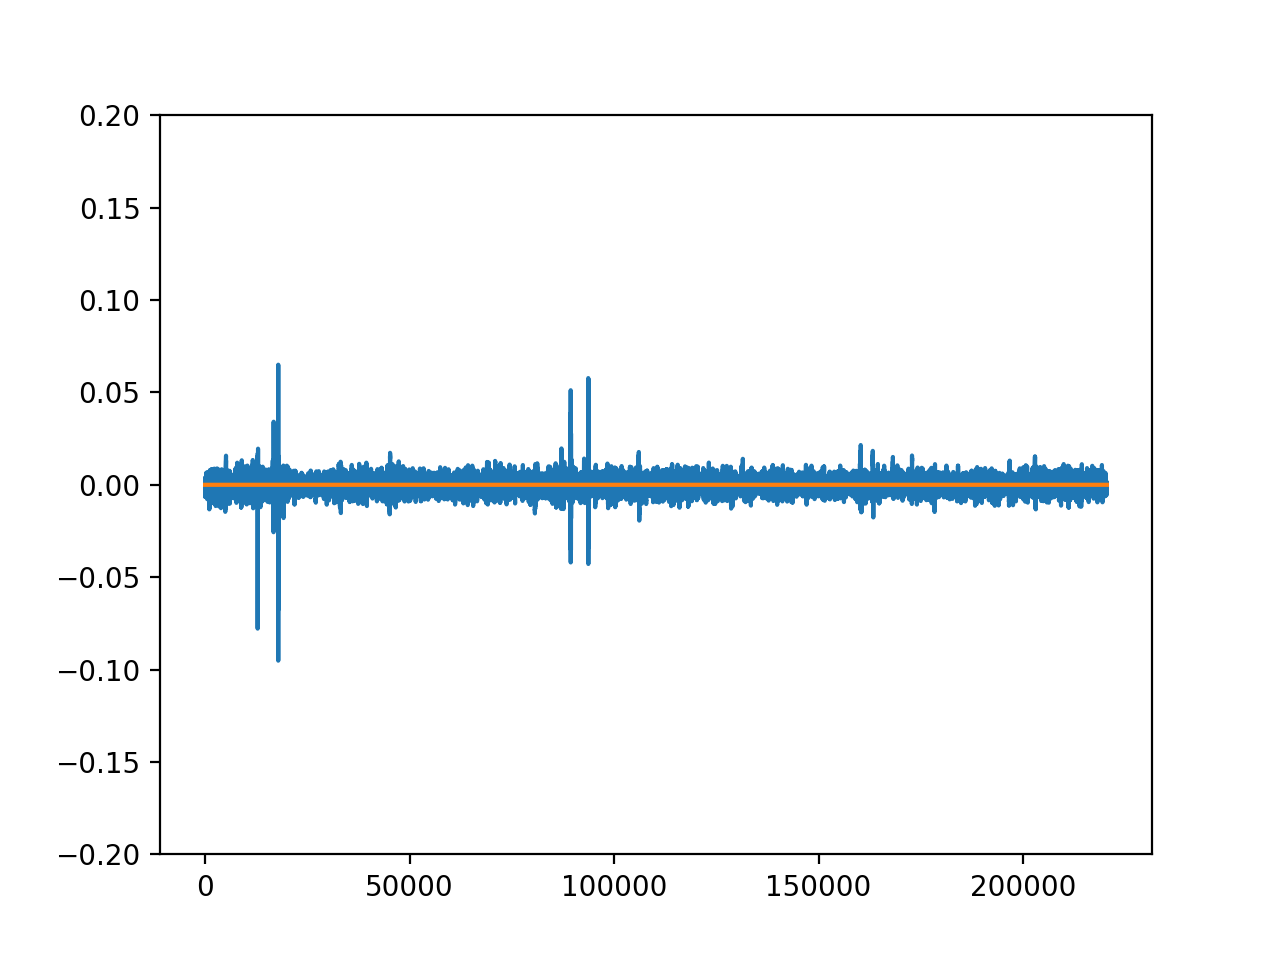

/Users/vincentqb/anaconda3/envs/audio/lib/python3.7/site-packages/ipykernel_launcher.py:82: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [5]:
# Iterate VAD

vad = VoiceActivityDetection()
speech_frames = []
chunks = []

fig, ax = plt.subplots(1,1)
m = .2
ax.set_ylim(-m,m)

with MicrophoneStream() as stream:
    audio_generator = stream.generator()
    chunk_length = stream._chunk
    waveform = torch.zeros(100*chunk_length)
    speechform = torch.zeros(100*chunk_length)
    try:
        for chunk in audio_generator:
            chunk = torch.tensor(chunk)# .view(1,-1)
            is_speech = vad.iter(chunk)
            # speech_frames.append(is_speech)
            # chunks.append(chunk)
            waveform[:-chunk_length] = waveform[chunk_length:]
            waveform[-chunk_length:] = chunk
            speechform[:-chunk_length] = speechform[chunk_length:]
            speechform[-chunk_length:] = int(is_speech)
            
            m = waveform.abs().max()
            if ax.lines:
                ax.lines[0].set_ydata(waveform)
                ax.lines[1].set_ydata(m*speechform)
                
                # Too slow
                
                # try:
                #     ax.lines[1].set_ydata(m*speechform)
                # except IndexError:
                #     ax.fill_between(list(range(waveform.size(-1))), -m*speechform, m*speechform, facecolor=colors[1], alpha=0.5)
                # try:
                #     ax.lines[2].set_ydata(speechform)
                # except IndexError:
                #     ax.fill_between(
                #         list(range(waveform.size(-1))),-m, m,
                #         where=speechform.numpy()>0.5, facecolor=colors[1], alpha=0.5
                #     )
            else:
                ax.plot(waveform)
                ax.plot(m*speechform)
                
                # Too slow
                
                # ax.fill_between(list(range(waveform.size(-1))), -m*speechform, m*speechform, facecolor=colors[1], alpha=0.5)
                # colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
                # ax.fill_between(
                #     list(range(waveform.size(-1))),-m, m,
                #     where=speechform.numpy()>0.5, facecolor=colors[1], alpha=0.5
                # )
            fig.canvas.draw()
            
    except KeyboardInterrupt:
        pass

<IPython.core.display.Javascript object>


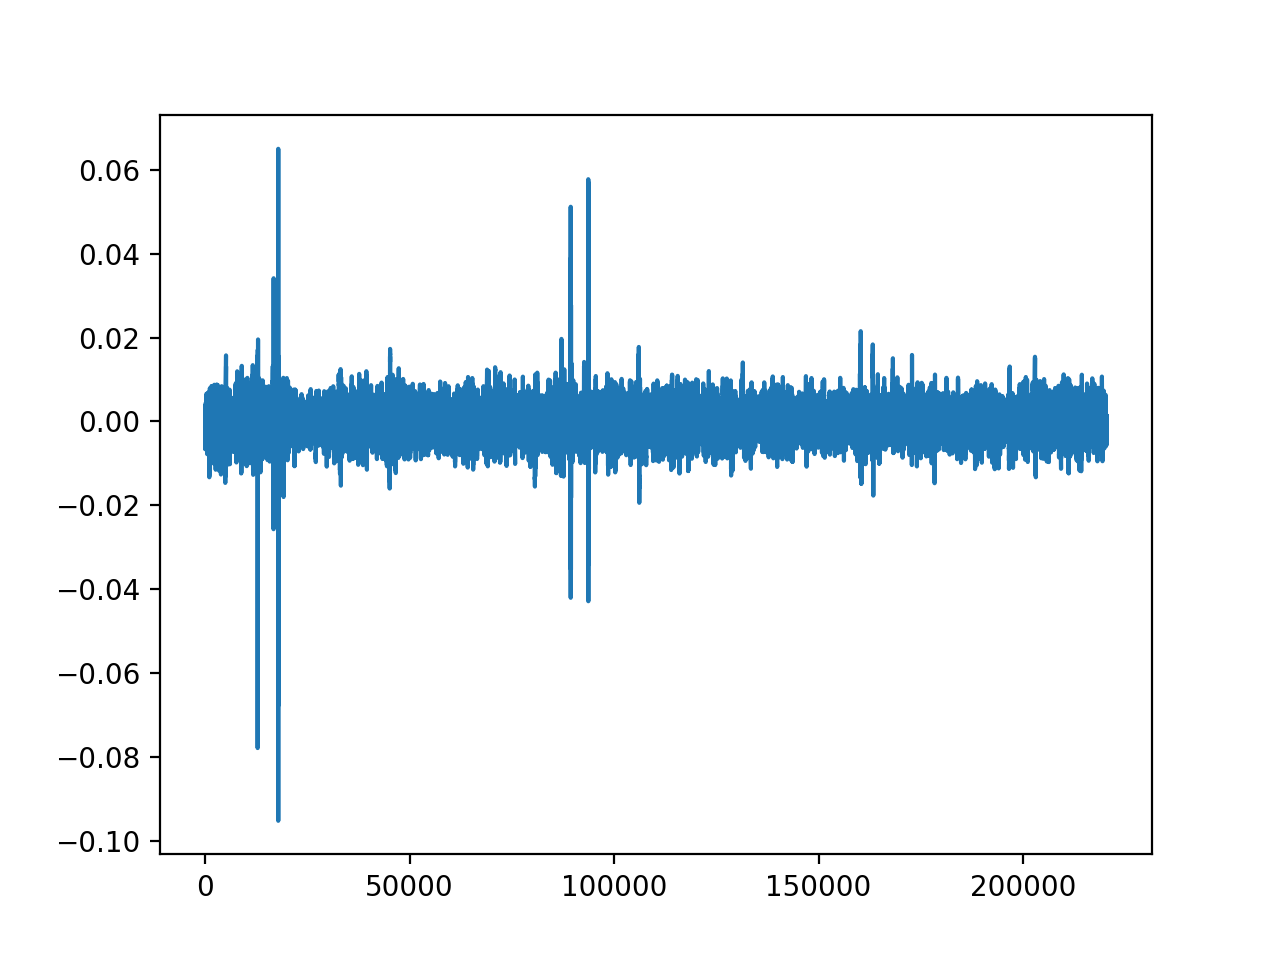

<IPython.core.display.Javascript object>


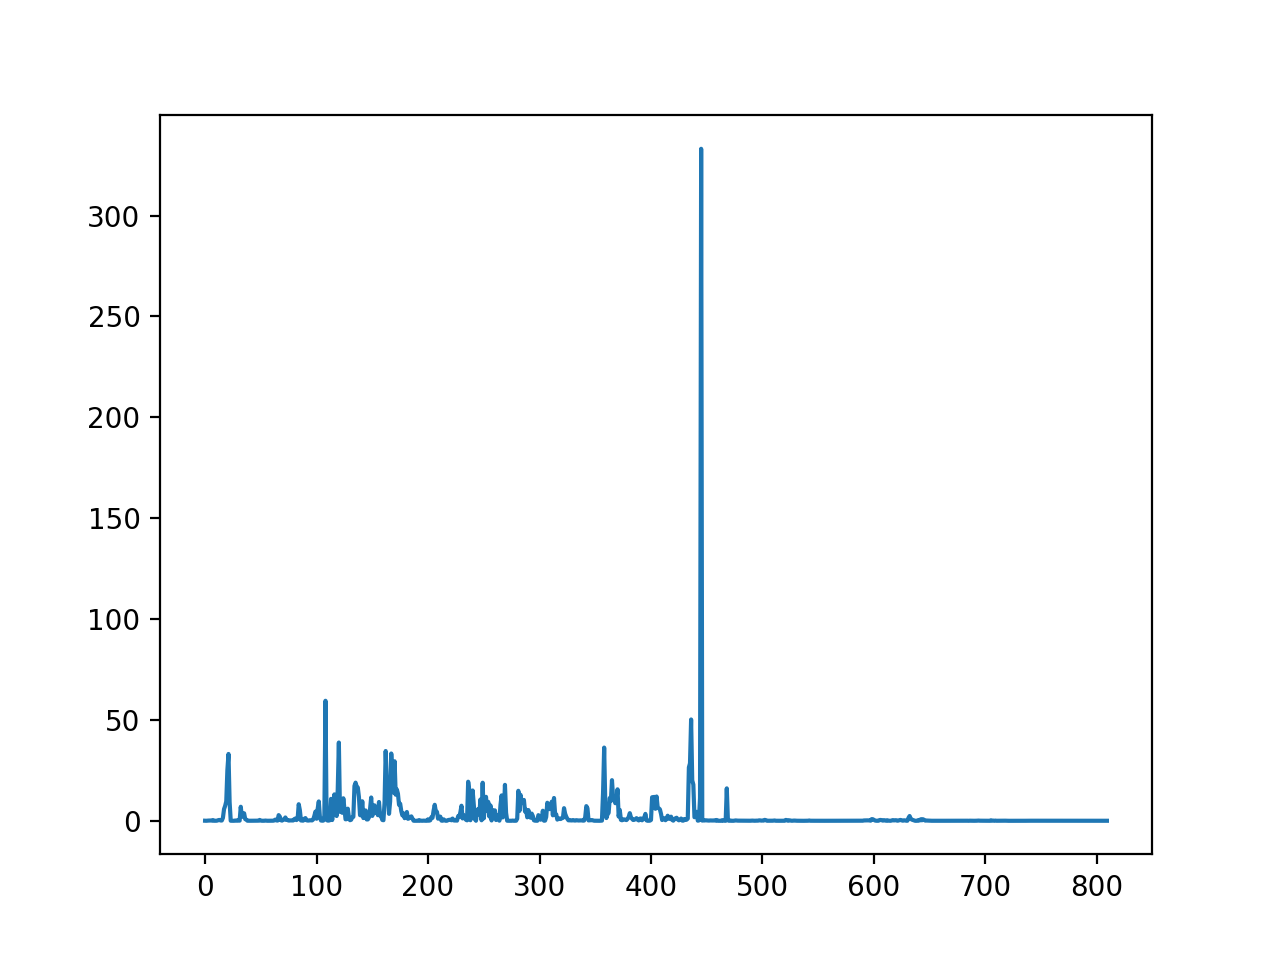

<IPython.core.display.Javascript object>


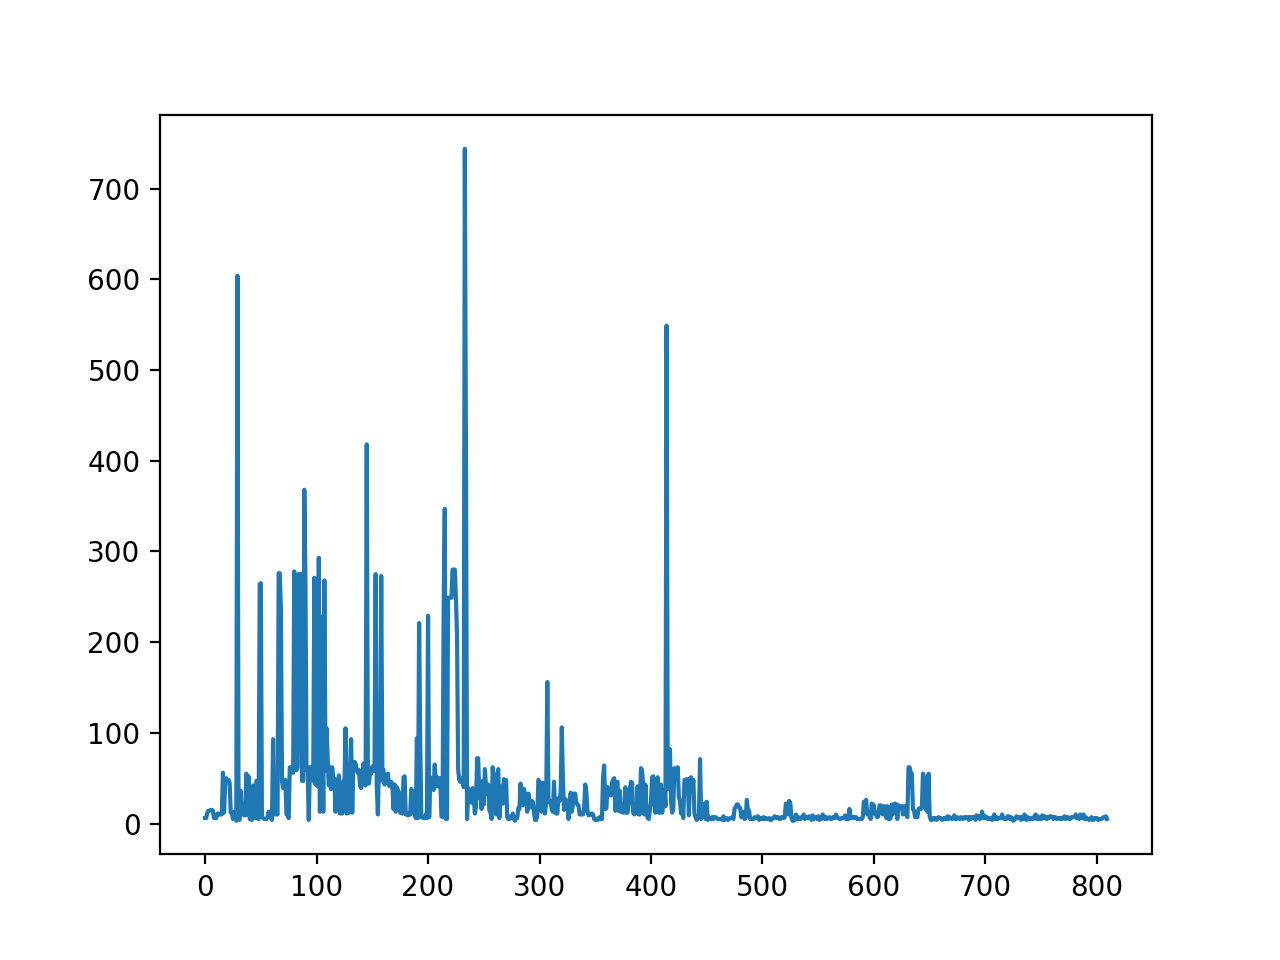

<IPython.core.display.Javascript object>


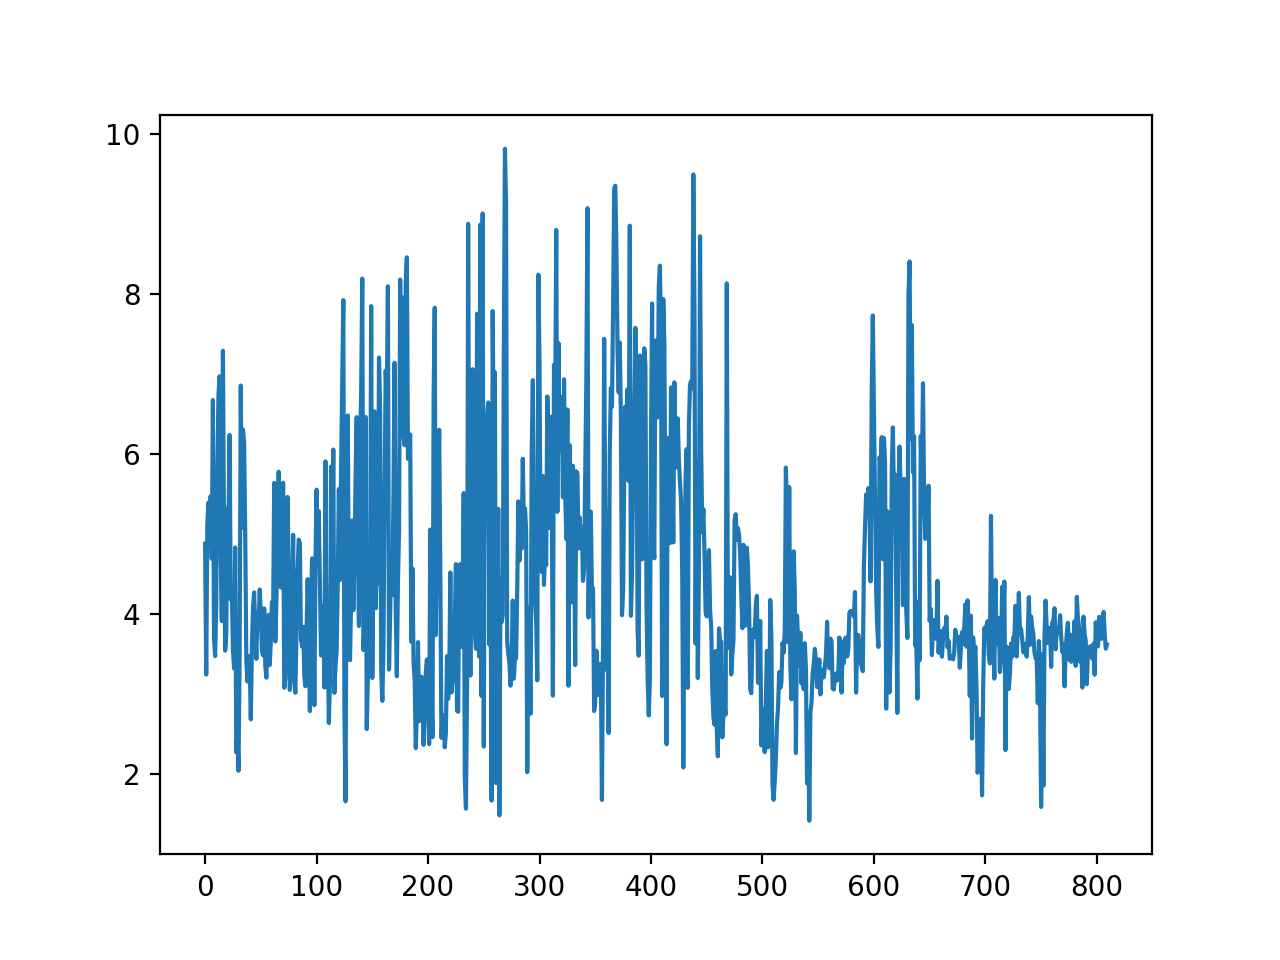

In [6]:
plt.figure()
plt.plot(waveform)

plt.figure()
plt.plot(vad.energy_list)
plt.figure()
plt.plot(vad.frequency_list)
plt.figure()
plt.plot(vad.spectral_flatness_list)